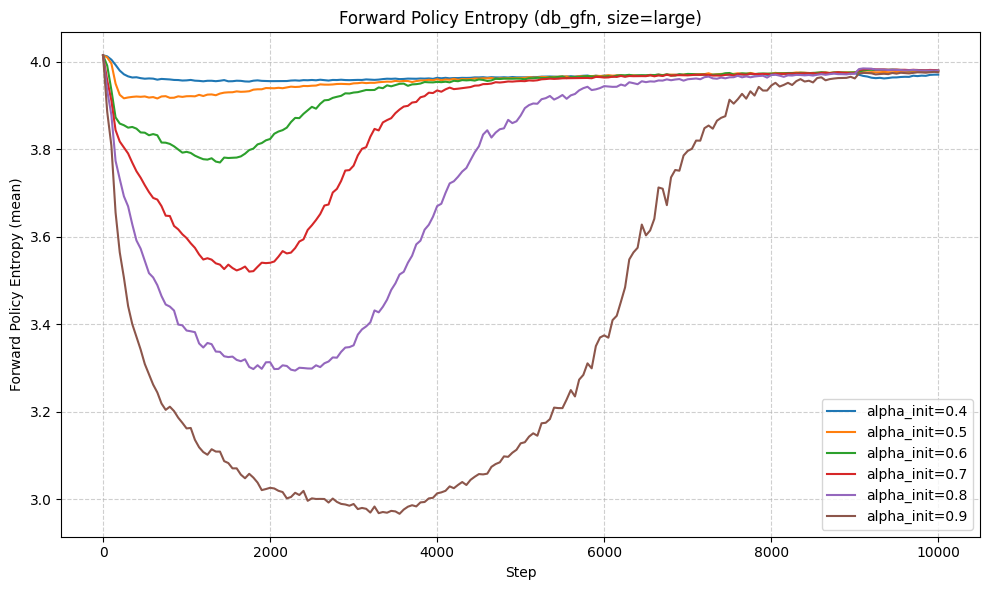

In [2]:
import json
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# === 读取json ===
with open("set_run_summary.json", "r") as f:
    data = json.load(f)

# === 正则解析实验名中的参数 ===
def parse_exp_name(name):
    # m(db_gfn)_a(0.7) 这种模式
    m_match = re.search(r"_m\((.*?)\)", name)
    a_match = re.search(r"_a\((.*?)\)", name)
    sz_match = re.search(r"_sz\((.*?)\)", name)
    return {
        "m": m_match.group(1) if m_match else None,
        "alpha_init": float(a_match.group(1)) if a_match else None,
        "size": sz_match.group(1) if sz_match else None,
    }

# === 聚合数据 ===
groups = defaultdict(list)

for exp_name, record in data.items():
    info = parse_exp_name(exp_name)
    if info["m"] == "db_gfn" and info["size"] == "large":
        alpha = info["alpha_init"]
        if 0.4 <= alpha <= 0.9:
            steps = record["step"]
            values = record["forward_policy_entropy_eval"]
            groups[alpha].append(values)

# === 计算均值 ===
mean_results = {}
for alpha, runs in groups.items():
    runs = np.array(runs)  # shape: (n_runs, n_steps)
    mean_results[alpha] = runs.mean(axis=0)

steps = record["step"]  # 假设所有实验的 step 相同

# === 绘图 ===
plt.figure(figsize=(10,6))
for alpha in sorted(mean_results.keys()):
    plt.plot(steps, mean_results[alpha], label=f"alpha_init={alpha}")

plt.xlabel("Step")
plt.ylabel("Forward Policy Entropy (mean)")
plt.title("Forward Policy Entropy (db_gfn, size=large)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [25]:
import json
import re
import numpy as np
import plotly.graph_objects as go
from collections import defaultdict
import plotly.io as pio

# === 读取json ===
with open("set_run_summary.json", "r") as f:
    data = json.load(f)

# === 正则解析实验名中的参数 ===
def parse_exp_name(name):
    m_match = re.search(r"_m\((.*?)\)", name)
    a_match = re.search(r"_a\((.*?)\)", name)
    sz_match = re.search(r"_sz\((.*?)\)", name)
    return {
        "m": m_match.group(1) if m_match else None,
        "alpha_init": float(a_match.group(1)) if a_match else None,
        "size": sz_match.group(1) if sz_match else None,
    }

# === 聚合数据 ===
groups = defaultdict(list)

for exp_name, record in data.items():
    if record["method"] == "tb_gfn" and record["size"] == "large" and record["fl"] == False:
        alpha = record["alpha_init"]
        if 0.4 <= alpha <= 0.9:
            steps = record["step"]
            values = record["forward_policy_entropy_eval"]
            groups[alpha].append(values)

# === 计算均值 ===
mean_results = {}
for alpha, runs in groups.items():
    runs = np.array(runs)  # shape: (n_runs, n_steps)
    mean_results[alpha] = runs.mean(axis=0)

steps = record["step"]  # 假设所有实验的 step 相同

# === Plotly 绘制折线图 ===
fig = go.Figure()

for alpha in sorted(mean_results.keys()):
    fig.add_trace(go.Scatter(
        x=steps,
        y=mean_results[alpha],
        mode="lines",
        name=fr"$\alpha={alpha}$"
    ))

fig.update_layout(
    width=800,   # 控制画布宽度
    height=500,  # 控制画布高度
    title=dict(
        text=r'$\alpha-\text{DB}$',
        font=dict(size=40, color="black"),   # 标题大且黑
        # 居中
        x=0.5,
        xanchor='center'
    ),
    xaxis=dict(
        title="Steps",
        title_font=dict(size=20, color="black"),  # x轴标题大且黑
        tickfont=dict(size=16, color="black")     # x轴刻度字体
    ),
    yaxis=dict(
        title="Average Forward Policy Entropy",
        title_font=dict(size=20, color="black"),  # y轴标题大且黑
        tickfont=dict(size=16, color="black")     # y轴刻度字体
    ),
    xaxis_title="Steps",
    yaxis_title="Average Forward Policy Entropy",
    legend=dict(
        # title="Alpha Init",
        x=0.79,   # 横向位置 (0=左, 1=右)
        y=0.01,   # 纵向位置 (0=底, 1=顶)
        xanchor="left",
        yanchor="bottom"
    ),
    template="plotly_white"
)
fig.update_xaxes(range=[0, 9000])
fig.write_html("test.html", include_mathjax="cdn")  # 或者 "require"
fig.show()
pio.write_image(fig, 'test4.pdf', width=800, height=500, include_mathjax="cdn")

TypeError: write_image() got an unexpected keyword argument 'include_mathjax'

In [ ]:
import pandas as pd
import ast

def plot_alpha_compare_large(set_csv_path='set.csv', png_out='alpha_compare_large.png', pdf_out='alpha_compare_large.pdf',annotate='ratio',annotate_decimals=2):
    """
    Plotly grouped bar chart on large set comparing two alphas per objective
      - db: 0.5 (Equal Weight) vs 0.9 (Mixed)
      - fl-db: 0.5 (Equal Weight) vs 0.9 (Mixed)
      - tb: 0.5 (Equal Weight) vs 0.7 (Mixed)
    Bars show mean of mean_top_1000_R, with line error bars = std across runs.
    Legend only: 'Equal Weight' vs 'Mixed'. No bar text or alpha labels on the plot.

    Saves only static images (PNG and PDF) using plotly's static image export.
    """
    import plotly.graph_objects as go
    import plotly.io as pio

    # Load & filter
    df = pd.read_csv(set_csv_path)
    df = df[df['summary'].apply(lambda x: ast.literal_eval(x).get('step', None) == 9999)]
    df = df[df['summary'].apply(lambda x: ast.literal_eval(x).get('size', None) == 'large')]

    # Parse fields
    df['parsed'] = df['summary'].apply(parse_summary)
    df['alpha'] = df['parsed'].apply(lambda x: x.get('alpha_init', None))
    # df['mean_top_1000_R'] = df['parsed'].apply(lambda x: x.get('mean_top_1000_R', None))
    df['mean_top_1000_R'] = df['parsed'].apply(lambda x: x.get('mean_R', None))


    def _get_method(summary):
        method = summary.get('method', None)
        if method == 'db_gfn' and summary.get('fl', False):
            return 'fl_db_gfn'
        return method

    df['method'] = df['parsed'].apply(_get_method)
    method_to_obj = {'db_gfn': 'db', 'fl_db_gfn': 'fl-db', 'tb_gfn': 'tb'}
    df['objective'] = df['method'].map(method_to_obj)

    # Keep only needed objectives & alphas
    df = df[df['objective'].isin(['db', 'fl-db', 'tb'])]
    chosen = {'db': {"eq": 0.5, "mix": 0.9}, 'fl-db': {"eq": 0.5, "mix": 0.9}, 'tb': {"eq": 0.5, "mix": 0.7}}
    df = df[df.apply(lambda r: r['alpha'] in [chosen.get(r['objective'], {}).get('eq'), chosen.get(r['objective'], {}).get('mix')], axis=1)]

    # Aggregate mean and std per (objective, alpha)
    agg = df.groupby(['objective', 'alpha'])['mean_top_1000_R'].agg(['mean', 'std']).reset_index()

    objectives = ['db', 'fl-db', 'tb']
    eq_vals, eq_errs, mix_vals, mix_errs = [], [], [], []
    for obj in objectives:
        eq_alpha = chosen[obj]['eq']
        mix_alpha = chosen[obj]['mix']
        # Equal Weight
        r_eq = agg[(agg['objective'] == obj) & (agg['alpha'] == eq_alpha)]
        eq_vals.append(float(r_eq['mean'].iloc[0]) if len(r_eq) else np.nan)
        eq_errs.append(float(r_eq['std'].iloc[0]) if len(r_eq) else np.nan)
        # Mixed
        r_mix = agg[(agg['objective'] == obj) & (agg['alpha'] == mix_alpha)]
        mix_vals.append(float(r_mix['mean'].iloc[0]) if len(r_mix) else np.nan)
        mix_errs.append(float(r_mix['std'].iloc[0]) if len(r_mix) else np.nan)

    # Build Plotly figure
    objectives=[x.upper() for x in objectives]  # Uppercase labels
    fig = go.Figure()
    fig.add_bar(
        # name=r"$ \text{Vanilla GFN Objectives, } \alpha=0.5$',
        name=r"$\text{Vanilla GFN Objectives, } \alpha=0.5$",
        x=objectives,
        y=eq_vals,
        error_y=dict(type='data', array=eq_errs, visible=True),
    )
    fig.add_bar(
        name=r"$\alpha \text{-GFN Objectives, }\alpha \in (0,1)$",
        x=objectives,
        y=mix_vals,
        error_y=dict(type='data', array=mix_errs, visible=True),
    )

    fig.update_traces(width=0.4)   # 0~1 左右的比例，适当调小
    n = len(objectives)
    i_tb = objectives.index('TB')            # TB 在第几个
    legend_x = (i_tb + 0.5) / n              # TB 组中心在 paper 坐标中的 x（0~1）

    # 推荐的纵向位置（图内靠上），如有遮挡可把 0.92 调大/调小
    legend_y = 0.8
    fig.update_layout(
        barmode='group',
        # title='Alpha comparison on large set (mean_top_1000_R)',
        xaxis_title='Objective',
        yaxis_title='Average Reward',
        legend_title_text='',
        template='plotly_white',
        bargap=0.2,        # 类别之间的空隙（越大柱越窄）
        bargroupgap=0,    # 同一类别内两根柱之间的空隙（越大柱越窄）
        legend=dict(
            x=legend_x-0.18, y=legend_y,          # 放在图内左上角
            xanchor='left', yanchor='top',
            orientation='v',         # 竖排
            bgcolor='rgba(255,255,255,0.6)',  # 半透明白底，读数不会被遮
            bordercolor='rgba(0,0,0,0.2)',
            borderwidth=1,
            font=dict(size=10)       # 需要更紧凑可以再小一点
        ),
        # margin=dict(l=60, r=10, t=50, b=50)  # 稍微紧一点的页边距
        margin=dict(l=28, r=6, t=8, b=26)  # 稍微紧一点的页边距

    )
    # === 独立的水平/竖直虚线括号 + 左侧倍率文本（不改你既有设定） ===
    # 叠加线性 x 轴（仅用于精确放置，不影响原图）
    n_groups = len(objectives)
    fig.update_layout(
        xaxis2=dict(
            type='linear', overlaying='x',
            range=[-0.5, n_groups - 0.5],
            showgrid=False, ticks='', showticklabels=False, anchor='y'
        )
    )

    # import plotly.graph_objects as go
    idx = np.arange(n_groups)

    # 与你的柱宽一致：update_traces(width=0.4) → 半宽 0.20
    bar_half = 0.20        # 柱子半宽
    delta    = 0.20        # 组内左右两柱相对组中心的偏移
    cap_len  = 0.4        # 顶部短横线长度（可调，小则更像“一个点”）
    vpad_x   = 0        # 竖线相对“低柱左边缘”再向左的距离（确保不压到柱/误差条）
    gap_y    = 0.01 * np.nanmax([*eq_vals, *mix_vals])  # 横/竖线在 y 方向的分离缝

    for i in range(n_groups):
        if not (np.isfinite(eq_vals[i]) and np.isfinite(mix_vals[i])):
            continue

        # 若要对齐误差条顶端，把下两行改为 +eq_errs / +mix_errs
        y_high = max(eq_vals[i], mix_vals[i])    # 高柱顶
        y_low  = min(eq_vals[i], mix_vals[i])    # 低柱顶
        y_cap = mix_vals[i]
        sep = 0.001 * max(abs(eq_vals[i]), abs(mix_vals[i]), 1.0)

        # 判定哪根是低柱，拿到它的“左边缘”
        low_is_eq     = (eq_vals[i] <= mix_vals[i])
        low_center_x  = (i - delta) if low_is_eq else (i + delta)
        low_left_edge = low_center_x - bar_half

        # 竖线放在低柱左边缘再向左一点；横线在 y_high+gap_y；竖线从 y_high-gap_y 到 y_low（两者留缝）
        x_line      = low_left_edge - vpad_x
        x_cap_left  = x_line 
        x_cap_right = x_line + cap_len


        # 顶部“帽檐”水平虚线（在竖线右侧或左侧按你现有 x_cap_left/x_cap_right）
        fig.add_shape(
            type='line', xref='x2', yref='y',
            x0=x_cap_left, x1=x_cap_right,
            y0=y_cap, y1=y_cap,                                # ← 这里与橙色柱顶持平
            line=dict(color='rgba(0,0,0,0.65)', width=1.2, dash='dash')
        )

        # 竖直虚线（与横线分开，从 y_cap - sep 开始，指向低柱顶）
        fig.add_shape(
            type='line', xref='x2', yref='y',
            x0=x_line, x1=x_line,
            y0=y_cap - sep, y1=y_low,                          # ← 起点略低于帽檐，避免连成一体
            line=dict(color='rgba(0,0,0,0.65)', width=1.2, dash='dash')
        )

        ratio_val = (mix_vals[i]/eq_vals[i]) if (np.isfinite(eq_vals[i]) and eq_vals[i] != 0) else np.nan
        if np.isfinite(ratio_val):
            ratio_txt = f"<b>{ratio_val:.{annotate_decimals}f}×</b>"  # ← 加粗
            y_mid = 0.5 * (y_high + y_low)
            fig.add_annotation(
                x=x_line + 0.37, y=y_mid, xref='x2', yref='y',
                text=ratio_txt, showarrow=False,
                xanchor='right', yanchor='middle',
                font=dict(size=14)  # ← 放大字号（可调 12~14）
            )

        # 去掉竖直网格线（以及 x 轴零线），保留 y 轴横向网格
    fig.update_xaxes(showgrid=False, zeroline=False)
    fig.update_yaxes(showgrid=True)  # 想更淡可加：gridcolor='rgba(0,0,0,0.08)'


    # Save PNG and PDF only
    try:
        pio.write_image(fig, png_out,scale=2)
    except Exception as e:
        print(f"PNG export failed: {e}")
    try:
        pio.write_image(fig, pdf_out,scale=2)
    except Exception as e:
        print(f"PDF export failed: {e}")

In [16]:
import json
import re
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from collections import defaultdict

# === 读取json ===
with open("set_run_summary.json", "r") as f:
    data = json.load(f)

# === 正则解析实验名中的参数 ===
def parse_exp_name(name):
    m_match = re.search(r"_m\((.*?)\)", name)
    a_match = re.search(r"_a\((.*?)\)", name)
    sz_match = re.search(r"_sz\((.*?)\)", name)
    fl_match = re.search(r"fl", name)
    return {
        "m": m_match.group(1) if m_match else None,
        "alpha_init": float(a_match.group(1)) if a_match else None,
        "size": sz_match.group(1) if sz_match else None,
        "fl": True if fl_match else False
    }

# === 三个子图设置 ===
subplots_config = [
    {"objective": "db_gfn", "fl": False, "title": r"$\text{DB}$"},
    {"objective": "db_gfn", "fl": True,  "title": r"$\text{FL-DB}$"},
    {"objective": "tb_gfn", "fl": False, "title": r"$\text{TB}$"},
]

fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=[cfg["title"] for cfg in subplots_config]
)

for col_idx, cfg in enumerate(subplots_config, start=1):
    # === 聚合数据 ===
    groups = defaultdict(list)
    for exp_name, record in data.items():
        if record["method"] == cfg["objective"] and record["fl"] == cfg["fl"] and record["size"] == "large":
            alpha = record["alpha_init"]
            if 0.4 <= alpha <= 0.9:
                steps = record["step"]
                values = record["forward_policy_entropy_eval"]
                groups[alpha].append(values)
    
    # === 计算均值 ===
    mean_results = {}
    for alpha, runs in groups.items():
        runs = np.array(runs)  # shape: (n_runs, n_steps)
        mean_results[alpha] = runs.mean(axis=0)
    
    # === 添加到子图 ===
    for alpha in sorted(mean_results.keys()):
        fig.add_trace(
            go.Scatter(
                x=steps,
                y=mean_results[alpha],
                mode="lines",
                name=fr"$\alpha={alpha}$",
                showlegend=(col_idx==1)  # 只在第一列显示图例
            ),
            row=1, col=col_idx
        )

# === 全局布局 ===
fig.update_layout(
    width=1800,   # 总画布宽度
    height=500,   # 高度保持不变
    title=dict(
        text=r'$\alpha-\text{DB}$',
        font=dict(size=40, color="black"),
        x=0.5,
        xanchor='center'
    ),
    xaxis=dict(
        title="Steps",
        title_font=dict(size=20, color="black"),
        tickfont=dict(size=16, color="black"),
        # side="bottom"
    ),
    yaxis=dict(
        title="Average Forward Policy Entropy",
        title_font=dict(size=20, color="black"),
        tickfont=dict(size=16, color="black")
    ),
    legend=dict(
        x=0.66, y=0.01,
        xanchor="left", yanchor="bottom"
    ),
    template="plotly_white"
)

# 设置所有子图的 x 轴范围一致
fig.update_xaxes(range=[0, 9000], row=1, col=1)
fig.update_xaxes(range=[0, 9000], row=1, col=2)
fig.update_xaxes(range=[0, 9000], row=1, col=3)

fig.write_html("test_three_subplots.html", include_mathjax="cdn")
fig.show()
pio.write_image(fig, 'test4.pdf', width=800, height=300)